In [164]:
#Packages to Run WebScraper
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import urllib3
urllib3.disable_warnings()
import seaborn as sns
import palettable
import re

plt.rcParams['figure.facecolor']='w'

In [154]:
#Insert Title of Show you went to Chart between the Quotes
Show='The Sopranos'

In [155]:
#Replace Spaces for Query
Show=Show.replace(' ','+')
search_query='https://www.imdb.com/find?q='+Show

#Initiate UrlLib Pool Manager
http = urllib3.PoolManager()
r = http.request('GET', search_query)
#Start HTML Parser
soup = BeautifulSoup(r.data, 'html.parser')

#Find Results Table Entries
res = soup.find_all('td', {'class' : 'result_text'})
#Enumerate thru Results to First Result then Break
for item in res:
    links=item.find_all('a')
    for link in links:
        show_href=link['href']
        break
    break

#Remove QueryString
show_href=show_href.split('?')[0]
site_main='https://www.imdb.com'+show_href+'episodes'
#print(site_main)

In [156]:
#Load Site to Get Some Basic MetaData for Chart
site_ = site_main+'?season=1'
http = urllib3.PoolManager()
r = http.request('GET', site_)

#Start BeautifulSoup Parser
soup = BeautifulSoup(r.data, 'html.parser')

#Identify Number of Seasons by Dropdown
selects = soup.find_all('select', {'id' : 'bySeason'})
lines = [select.get_text() for select in selects]
seasons=re.findall('\d+',str(lines))

#Title of Tv Show
title=soup.find('title')
title=title.get_text().split('-')[0]



In [157]:
df_all=pd.DataFrame()

for season_num in seasons:
    print("Scraping Season:"+season_num+" of "+title)
    #Initialize URL
    site_ = site_main+'?season='+season_num
    http = urllib3.PoolManager()
    r = http.request('GET', site_)
    #Begin Parser
    soup = BeautifulSoup(r.data, 'html.parser')
    spans = soup.find_all('span', {'class' : 'ipl-rating-star__rating'})

    #enumerate spans with rating information
    lines = [span.get_text() for span in spans]
    
    if (len(lines)>0):
        #remove non-numeric values
        df_season=pd.DataFrame(pd.to_numeric(lines,errors='coerce'))
        df_season=df_season.dropna()

        #Extract every 12th to ignore 0-10 Rating
        df_season=df_season.iloc[::12]

        #ReZero Index to Get Episode Number
        df_season=df_season.reset_index(drop=True)

        df_season.loc[:,'Season']=season_num
        df_season.loc[:,'EpisodeNum']=df_season.index+1

        df_season.columns=['Rating','Season','Episode Number']

        #Add Season Data to Aggregate DataFrame
        df_all=pd.concat([df_all,df_season])

Scraping Season:1 of Rodina Sopránů 
Scraping Season:2 of Rodina Sopránů 
Scraping Season:3 of Rodina Sopránů 
Scraping Season:4 of Rodina Sopránů 
Scraping Season:5 of Rodina Sopránů 
Scraping Season:6 of Rodina Sopránů 


In [158]:
df_pivot.index=df_pivot.index.astype(int)
df_pivot=df_pivot.sort_index()

In [162]:
df_pivot.min().min()

7.9

Text(0.5, 1.0, 'Rodina Sopránů  IMDB Ratings\n')

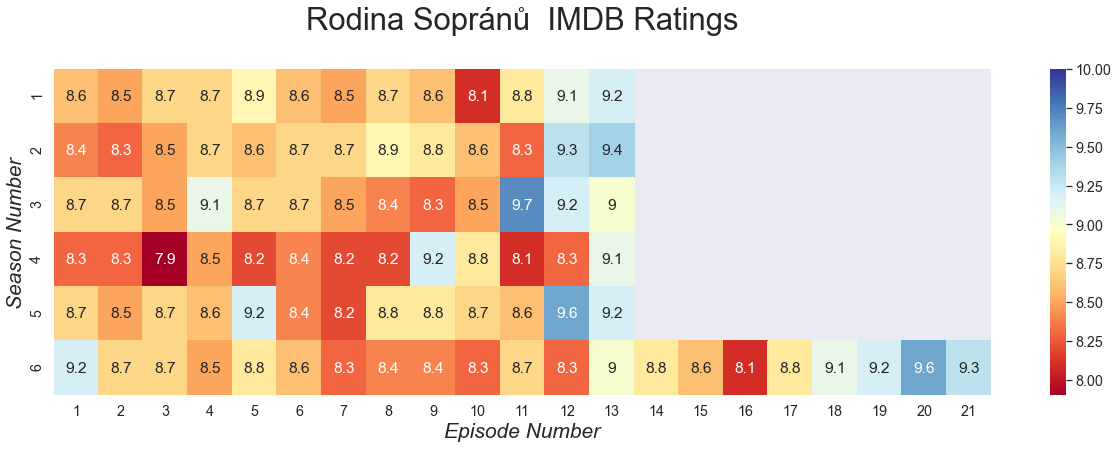

In [163]:

cmap=palettable.colorbrewer.diverging.RdYlBu_11.get_mpl_colormap()
sns.set(font_scale = 1.3)

#Convert Tidy Data to Pivoted Data
df_pivot=df_all.pivot(index='Season',columns='Episode Number')
#Remove MultiIndex 
df_pivot.columns=df_pivot.columns.droplevel()
#Find Index Original Sorting by Numer as String
df_pivot.index=df_pivot.index.astype(int)
df_pivot=df_pivot.sort_index()

ysize,xsize=df_pivot.shape
size=np.max((xsize,ysize))

fig,ax=plt.subplots(figsize=(xsize,ysize))

#Use Seaborn Heatmap
sns.heatmap(df_pivot,annot=True,cmap=cmap,vmin=df_pivot.min().min(),vmax=10)

ax.set_xlabel('Episode Number',fontsize=np.int(1*size),style='italic')
ax.set_ylabel('Season Number',fontsize=np.int(1*size),style='italic')
ax.set_title(title+' IMDB Ratings\n',fontsize=np.int(1.5*size))